In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
import scipy.stats as stats

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#Inspect the columns of our table "measurement":
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#Inspect the columns of our table "station":
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Identify the date of the last data point:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [13]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).all()

results

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'prcp'])
#Converting date column as object to datetime value
df['date'] = pd.to_datetime(df.date)
#Setting up the index
df.set_index('date', inplace=True)
#Replace the Null values by 0
df = df.fillna(0)
# Sort the dataframe by date
df.sort_values("date")
df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


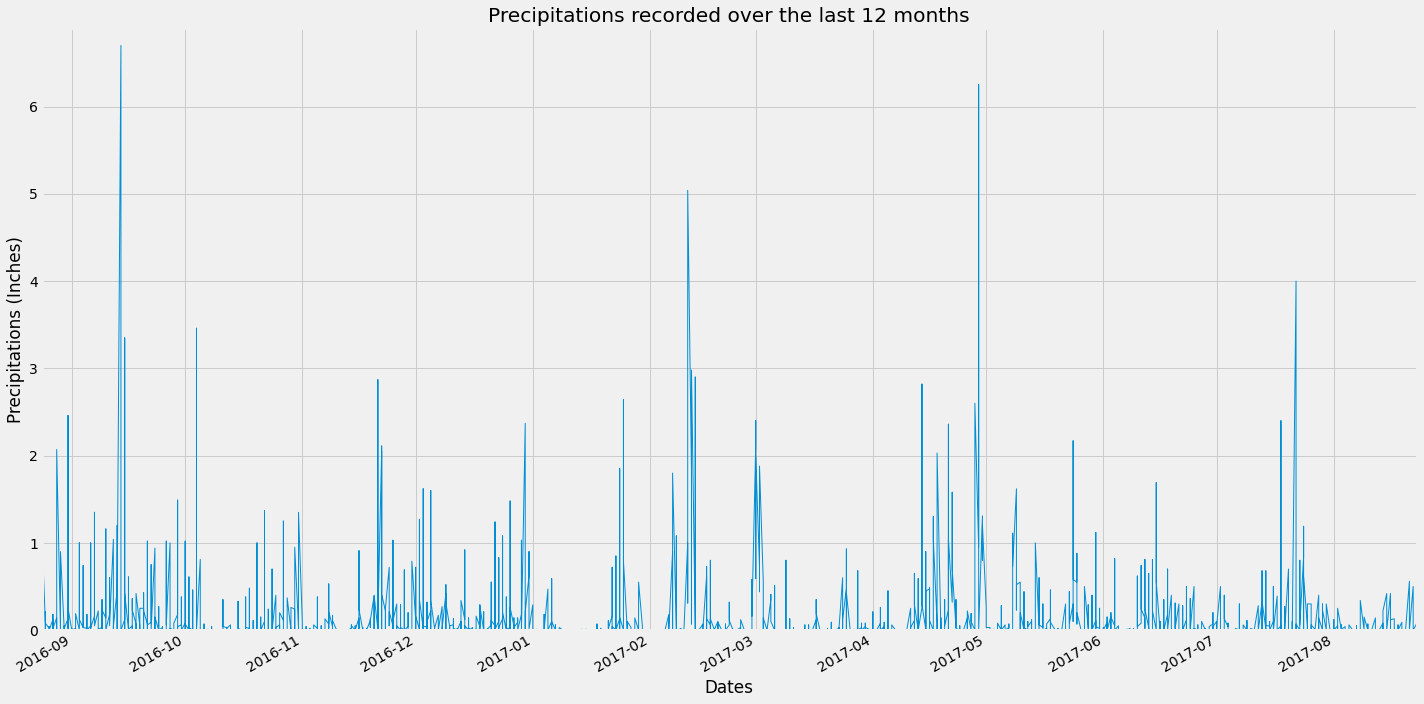

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(linewidth = 1, figsize = (20,10),legend=None)
# Set textual properties
plt.title("Precipitations recorded over the last 12 months")
plt.ylabel("Precipitations (Inches)")
plt.xlabel("Dates")
plt.xlim(min(df.index),max(df.index))
plt.ylim(0,max(df.prcp)+0.2)
# Show plot
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.station)).all()
stations

[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_high_avg_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
low_high_avg_temp

for record in low_high_avg_temp:
    (low, high, avg) = record
    print (f"The lowest temperature is {low:.2f}.")
    print (f"The highest temperature is {high:.2f}.")
    print (f"The average temperature is {avg:.2f}.")

The lowest temperature is 54.00.
The highest temperature is 85.00.
The average temperature is 71.66.


In [21]:
# Choose the station with the highest number of temperature observations.
highest_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()
highest_tobs

('USC00519281', 2772)

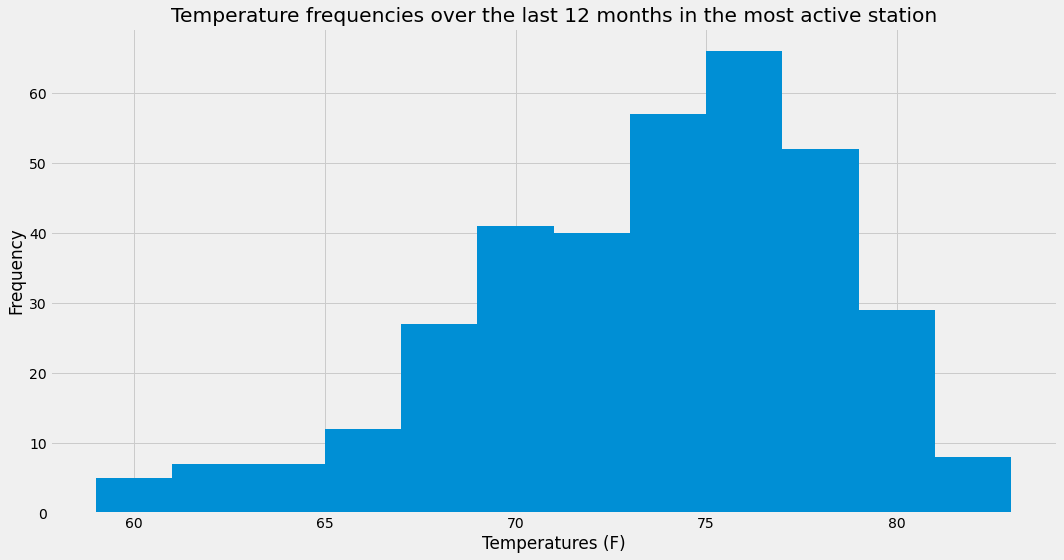

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = session.query(Measurement.tobs).\
    filter(Measurement.date > year_ago).\
    filter(Measurement.station == 'USC00519281').all()
#Converting the data into a dataframe to plot the histogram
df2 = pd.DataFrame(temperatures, columns=['temperatures'] )
df2.plot.hist(bins=12, figsize=(15,8), legend = None)
#Titles and axis
plt.title("Temperature frequencies over the last 12 months in the most active station")
plt.ylabel("Frequency")
plt.xlabel("Temperatures (F)")
#Showing the histogram
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

# Temperature Analysis I

In [23]:
#Identify the average temperature in June across all stations in the dataset.
df3 = pd.read_csv("Resources/hawaii_measurements.csv")
df3.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [24]:
#Convert string dates to datetime dates
df3['date'] = pd.to_datetime(df3.date)

In [25]:
#Select all the observations that happened in June every year
June_df = df3.loc[df3['date'].dt.month == 6]
June_df.head()

,station,date,prcp,tobs
133,USC00519397,2010-06-01,0.00,78
134,USC00519397,2010-06-02,0.01,76
135,USC00519397,2010-06-03,0.00,78
136,USC00519397,2010-06-04,0.00,76
137,USC00519397,2010-06-05,0.00,77


In [26]:
#Calculate the mean of the June temperature observations
Jun_avg = June_df['tobs'].mean()
Jun_avg

74.94411764705882

In [27]:
#Select all the observations that happened in December every year
Dec_df = df3.loc[df3['date'].dt.month == 12]
Dec_df.head()

,station,date,prcp,tobs
305,USC00519397,2010-12-01,0.04,76
306,USC00519397,2010-12-03,0.00,74
307,USC00519397,2010-12-04,0.00,74
308,USC00519397,2010-12-06,0.00,64
309,USC00519397,2010-12-07,0.00,64


In [28]:
#Calculate the mean of the December temperature observations
Dec_avg = Dec_df['tobs'].mean()
Dec_avg

71.04152933421226

In [29]:
#T-test to determine whether the difference in the means, if any, is statistically significant. 
#On this occasion we will use an independent (two sample) T-test as the two samples represents different times of the population.
stats.ttest_ind(June_df['tobs'], Dec_df['tobs'], equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

### Conclusion:
The pvalue is extremely small well below 0.05, therefore we can confirm the difference in the means is statistically significant.

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#My trip is from 1 September 2020 until 30 September 2020
temps =(calc_temps('2016-09-01', '2016-09-30'))
temps
#Convert temps into a dataFrame
df_temps = pd.DataFrame(temps, columns=["Min_temp", 'Avg_temp', "Max_temp"])
df_temps

,Min_temp,Avg_temp,Max_temp
0,70.0,77.747368,84.0


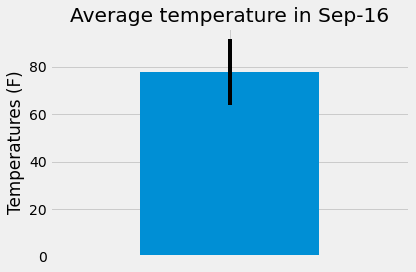

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
Avg_temp = df_temps["Avg_temp"]
error = [df_temps['Max_temp']-df_temps['Min_temp']]
plot = Avg_temp.plot(kind='bar',yerr=error)
#Titles and axis
plt.title("Average temperature in Sep-16")
plt.ylabel("Temperatures (F)")
plt.xticks(df_temps.index, " ")
#Showing the histogram
plt.tight_layout()
plt.show()

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def tot_rain(start_date, end_date):
  
    return session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, 
                         func.sum(Measurement.prcp)).\
            filter(Station.station == Measurement.station).\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).all()
#USing the function on our dates trip:
rain = tot_rain('2016-09-01','2016-09-30')
#Place the data in a dataframe
rain_df = pd.DataFrame(rain, columns=['Station', 'Station Name',"Latitude","Longitude",'Elevation','Precipitation'])
#Setting up the index
rain_df.set_index('Station', inplace=True)
rain_df

,Station Name,Latitude,Longitude,Elevation,Precipitation
Station,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,26.85
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,8.31
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,4.32
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,3.93
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.76
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.13
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.10


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals= []
# Set the start and end date of the trip
start_trip = "2016-09-01"
end_trip = '2016-09-30'
# Use the start and end date to create a range of dates
range = pd.date_range(start_trip,end_trip)
# Stip off the year and save a list of %m-%d strings
month = []
for date in range:
    date = date.strftime("%m-%d")
    month.append(date)
print(month)

['09-01', '09-02', '09-03', '09-04', '09-05', '09-06', '09-07', '09-08', '09-09', '09-10', '09-11', '09-12', '09-13', '09-14', '09-15', '09-16', '09-17', '09-18', '09-19', '09-20', '09-21', '09-22', '09-23', '09-24', '09-25', '09-26', '09-27', '09-28', '09-29', '09-30']


In [36]:
# Loop through the list of %m-%d strings and calculate the normals for each date
for m in month:
    results = daily_normals(m)
    normals.append(results)
print(normals)

[[(69.0, 77.0, 82.0)], [(67.0, 76.66666666666667, 83.0)], [(69.0, 76.13725490196079, 83.0)], [(68.0, 76.27083333333333, 84.0)], [(66.0, 75.91489361702128, 84.0)], [(66.0, 74.91111111111111, 81.0)], [(64.0, 75.18, 82.0)], [(66.0, 76.22222222222223, 83.0)], [(68.0, 76.36538461538461, 84.0)], [(67.0, 76.61224489795919, 85.0)], [(70.0, 76.69565217391305, 83.0)], [(68.0, 75.89795918367346, 85.0)], [(68.0, 75.875, 82.0)], [(69.0, 75.98076923076923, 85.0)], [(67.0, 76.14, 81.0)], [(70.0, 77.40384615384616, 86.0)], [(68.0, 76.57692307692308, 83.0)], [(67.0, 75.85106382978724, 84.0)], [(68.0, 76.34693877551021, 87.0)], [(69.0, 76.14583333333333, 83.0)], [(67.0, 76.44897959183673, 84.0)], [(69.0, 76.37254901960785, 84.0)], [(67.0, 75.82692307692308, 83.0)], [(69.0, 77.02, 85.0)], [(69.0, 76.14893617021276, 83.0)], [(66.0, 75.64, 85.0)], [(68.0, 75.64, 83.0)], [(67.0, 76.13461538461539, 84.0)], [(68.0, 75.97872340425532, 83.0)], [(67.0, 75.3061224489796, 83.0)]]


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=["MinTemp",'AvgTemp','MaxTemp'])
#Setting up the index
#normals_df.set_index('month', inplace=True)
normals_df

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
